**2024/10/22**

- Part 1: This script generates HDF5 file which contains measurement values from MLCWs
- Part 2: Add metadata

In [1]:
import pinyin
from appgeopy import *
from my_packages import *

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [2]:
def differ_to_ref(series, convert_to=None):
    """
    Calculate differential values relative to the first measurement in the series.

    Parameters:
    - series (pd.Series): A pandas Series containing the measurements.
    - convert_to (str or None): Unit to convert the differential values to.
                                Accepts 'milimeter', 'centimeter', or None for 'meters'.

    Returns:
    - np.ndarray: The differential values converted to the specified unit.

    Raises:
    - ValueError: If 'convert_to' is not 'milimeter', 'centimeter', or None.

    """
    # Determine the conversion multiplier based on the desired unit.
    if convert_to == "milimeter":
        multiplier = 1000
    elif convert_to == "centimeter":
        multiplier = 100
    elif convert_to is None:
        multiplier = 1  # Keep the original unit (meters).
    else:
        raise ValueError("Invalid 'convert_to' value. Must be 'milimeter', 'centimeter', or None for meters.")

    # Calculate differential values relative to the first measurement and apply conversion.
    return np.array((series - series.iloc[0]) * multiplier, dtype=np.float16)


# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
def cdisp_from_base(input_array):
    cdisp_ref_to_base = np.nancumsum(input_array[::-1], dtype=np.float64)
    return cdisp_ref_to_base[::-1]


# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
def numeric_depth(input_array):
    string_to_num = [eval(ele.split("_")[-1].split("m")[0]) for ele in input_array]
    round_num = np.round(string_to_num, 3)
    return round_num

In [56]:
data_dir = r"D:\1000_SCRIPTS\003_Project002\20241016_MLCW_to_HDF5\XZ_to_Excel"

# Retrieve all well data file paths
data_fpath = glob(os.path.join(data_dir, "*.xlsx"))

select_fpath = r"D:\1000_SCRIPTS\003_Project002\20241016_MLCW_to_HDF5\XZ_to_Excel\xiutan_秀潭.xlsx"

# Extract the basename of the file without the extension (e.g., "僑義").
basename = os.path.basename(select_fpath).split(".")[0]

# Extract Latin alphabetic words using regex
latin_words = re.findall(r'[a-zA-Z]+', basename)

# Join the extracted words into a single string if needed
ename = '_'.join(latin_words)

# Read the well data from the .xz file using pandas, resulting in a DataFrame.
well_df = pd.read_excel(select_fpath, index_col=[0], parse_dates=[0])
# # Ensure the index (date) of the DataFrame is in datetime format for time-based operations.
# well_df.index = pd.to_datetime(well_df.index)

well_df = well_df.fillna(axis=0, method="ffill")
well_df = well_df.fillna(axis=0, method="bfill")

column_diffs = well_df.diff(axis=1)
column_diffs.iloc[:, 0] = well_df.iloc[:, 0]

select_columns = well_df.columns[:-2]
filled_diffs = column_diffs.fillna(axis=0, method="ffill")
filled_diffs = filled_diffs.loc["12-2014":"2021", select_columns]

diffs_ref2first_transposed = filled_diffs.apply(lambda x: differ_to_ref(x), axis=0).transpose()
cdisp_ref2base = diffs_ref2first_transposed.apply(cdisp_from_base, axis="index")
cdisp_ref2base = cdisp_ref2base*100

In [57]:
result_df = pd.read_excel(r"E:\SUBSIDENCE_PROJECT_DATA\2024_MLCW_ANALYSIS\RawData\秀潭國小.xlsx", sheet_name='Sheet1', index_col=[0], parse_dates=[0])

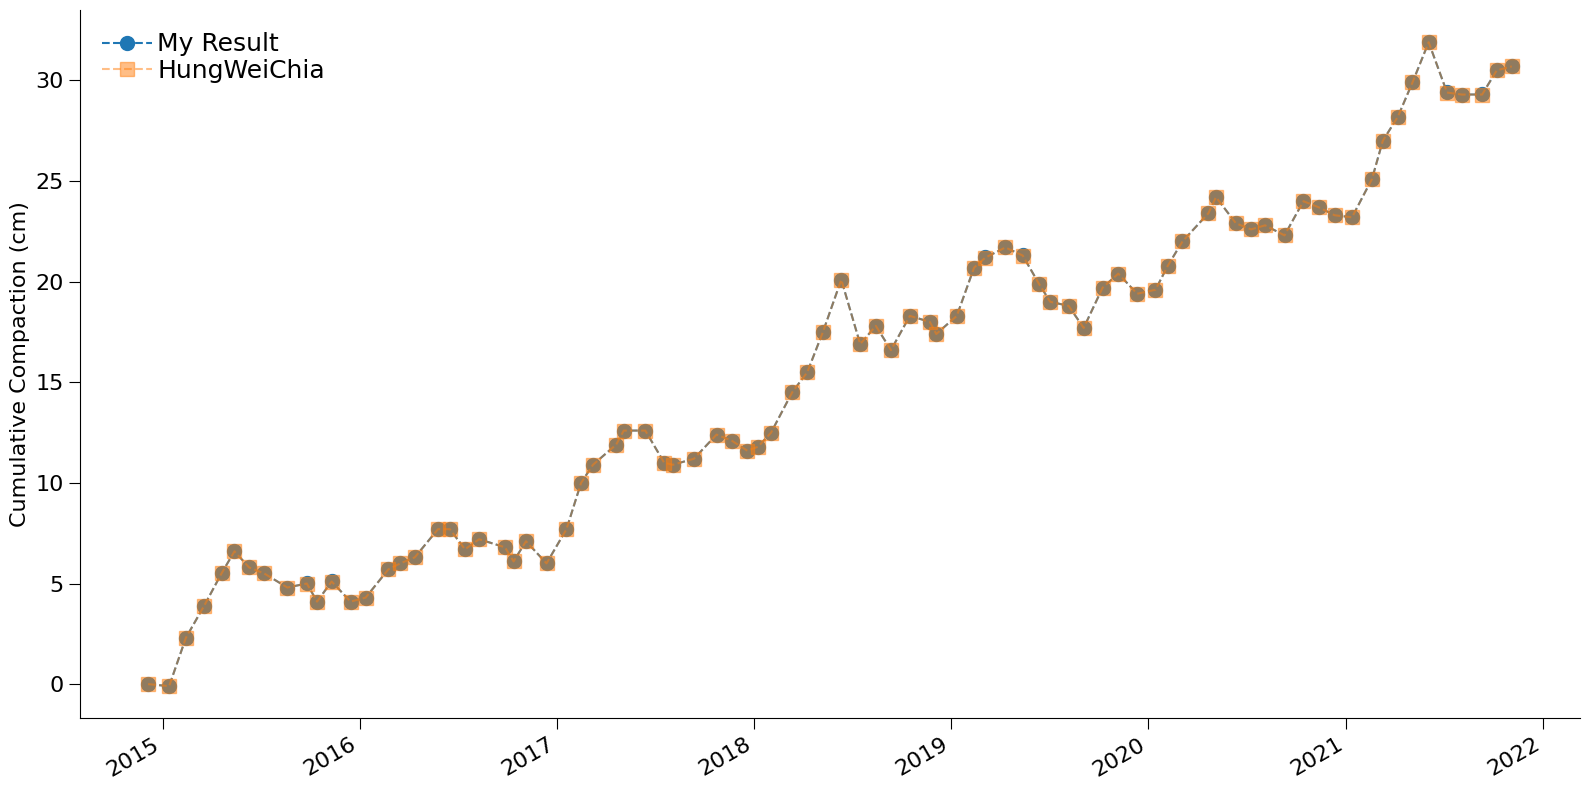

In [58]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
(-1*cdisp_ref2base.iloc[0, :]).plot(marker='o', linestyle='--', markersize=10, ax=ax, label='My Result')
result_df.iloc[:, 0].plot(marker='s', linestyle='--', markersize=10, ax=ax, label='HungWeiChia', alpha=0.5)
# Configure legend and datetime ticks
# Configure axis properties for the plot
visualize.configure_axis(
    ax,
    tick_direction="out",
    hide_spines=["top", "right"],
    major_tick_length=8,
    minor_tick_length=5,
    ylabel="Cumulative Compaction (cm)",
    fontsize_base=16
)
visualize.configure_legend(ax)
fig.tight_layout()
visualize.save_figure(fig, savepath="compare_MLCW_Xiutan.png", dpi=600)
plt.show()